In [535]:
import pandas as pd
from dtaidistance import dtw, similarity
import matplotlib.pyplot as plt
import numpy as np
from sklearn_extra.cluster import KMedoids

In [473]:
def goodall1_distance(x, y, N, frecuencias_df):
    similitudes = []
    for column in x.columns:
        if x[column].item() != y[column].item():
            similitud = 0
        
        else:
            f_x = frecuencias_df.loc[x[column].item(), column].item()
            f_consideradas = frecuencias_df[column][frecuencias_df[column] <= f_x]
            similitud = 1 - ((f_consideradas * (f_consideradas - 1))/(N * (N - 1))).sum()
        
        similitudes.append(similitud)

    return 1 - np.mean(similitudes)

def trayectorias_fitness_func(solution, cluster_labels, distancias_trayectorias_mtz):
    medoides_idx = []
    distancias_a_medoides = np.array([])
    for cluster_label in cluster_labels:
        distancias_trayectorias_cluster_mtz = distancias_trayectorias_mtz[np.ix_(solution == cluster_label, solution == cluster_label)].copy()

        medoide_cluster_idx = distancias_trayectorias_cluster_mtz.sum(axis=1).argmin()
        medoide_idx = (solution == cluster_label).cumsum().tolist().index(medoide_cluster_idx + 1)

        distancias_a_medoide_cluster = distancias_trayectorias_cluster_mtz[medoide_cluster_idx]

        medoides_idx.append(medoide_idx)
        distancias_a_medoides = np.append(distancias_a_medoides, distancias_a_medoide_cluster)

    distancias_entre_medoides = distancias_trayectorias_mtz[np.ix_(medoides_idx, medoides_idx)].copy()[0]

    return distancias_entre_medoides.mean() - distancias_a_medoides.mean()

def plot_time_series_clusters(df, solution, medoids, figsize=(14, 0.9)):
    """
    df: dataframe con columnas hba1c_1 ... hba1c_8
    solution: lista/array indicando cluster asignado a cada serie
    medoids: lista con índices de los medoids
    """
    
    # Convertir el DF a matriz (n_series x n_tiempos)
    data = df.values
    n_clusters = len(np.unique(solution))
    time_steps = df.columns
    
    fig, axes = plt.subplots(1, n_clusters, figsize=(figsize[0], figsize[1] * n_clusters))

    if n_clusters == 1:
        axes = [axes]

    for k in range(n_clusters):
        ax = axes[k]

        # series que pertenecen al cluster k
        cluster_indices = np.where(np.array(solution) == k)[0]
        cluster_series = data[cluster_indices]

        # plot de todas las series del cluster
        for s in cluster_series:
            ax.plot(time_steps, s, alpha=0.3, linewidth=1)

        # plot del medoid
        medoid_idx = medoids[k]
        medoid_series = data[medoid_idx]
        ax.plot(time_steps, medoid_series, color="black", linewidth=3, label="Medoid")

        ax.set_title(f"Cluster {k} (n={len(cluster_indices)})")
        ax.set_xlabel("Tiempo")
        ax.set_ylabel("HBA1c")
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_time_series_clusters_random(df, solution, figsize=(14, 0.9)):
    """
    df: DataFrame con columnas hba1c_1 ... hba1c_8
    solution: lista/array indicando cluster asignado a cada serie
    """
    
    data = df.values                    # matriz (n_series x n_tiempos)
    n_clusters = len(np.unique(solution))
    time_steps = df.columns

    fig, axes = plt.subplots(
        1, 
        n_clusters, 
        figsize=(figsize[0], figsize[1] * n_clusters)
    )

    if n_clusters == 1:
        axes = [axes]

    for k in range(n_clusters):
        ax = axes[k]

        # Series dentro del cluster k
        cluster_indices = np.where(np.array(solution) == k)[0]
        cluster_series = data[cluster_indices]

        # Plot de todas las series del cluster
        for s in cluster_series:
            ax.plot(time_steps, s, alpha=0.3, linewidth=1)

        # Elegir 1 serie aleatoria para remarcar
        rand_idx = np.random.choice(cluster_indices)
        rand_series = data[rand_idx]

        ax.plot(
            time_steps, 
            rand_series, 
            color="black", 
            linewidth=3,
            label=f"Serie destacada (idx={rand_idx})"
        )

        ax.set_title(f"Cluster {k} (n={len(cluster_indices)})")
        ax.set_xlabel("Tiempo")
        ax.set_ylabel("HBA1c")
        ax.legend()

    plt.tight_layout()
    plt.show()

In [5]:
data_df = pd.read_csv("base_isa_27oct2025.csv")
data_df.head()

,id,nombre,sexo_num,fec_nac,edad,resi_num,nac_num,ocupacion_num,estadocivil_num,escolaridad_num,...,sglt2_pos,tiazolin_pos,antid_orales_pos,ins_ultrar_pos,ins_rapid_pos,insul_inter_pos,indic_insul_pos,lugar_num,total_hba1c,tiene_8_hba1c
0,815,RAMÍREZ MARTÍNEZ JOSÉ LUIS,1,06mar1963,59,1,1,2,1,4,...,0,0,0,1,0,0,1,4.0,8,1
1,998,VILLALPANDO BRAVO LETICIA,2,29dec1965,52,1,1,2,3,3,...,0,0,1,0,0,0,0,4.0,8,1
2,176,CASAS GARCÍA JOSÉ ALFREDO,1,30mar1937,81,1,1,3,5,4,...,0,0,0,1,0,0,1,3.0,8,1
3,499,HERNANDEZ RODRIGUEZ FRANCISCO,1,27oct1943,73,2,1,2,1,1,...,0,0,1,1,0,1,1,4.0,8,1
4,984,VEGA TORRES DELIA CARMEN,2,13jun1933,80,1,1,2,3,3,...,0,0,1,0,0,0,0,4.0,8,1


In [6]:
columnas_trayectorias = data_df.columns[data_df.columns.str.startswith("hba1c")].tolist()

trayectorias_df = data_df[columnas_trayectorias].copy()
trayectorias_df = trayectorias_df[trayectorias_df.isna().sum(axis=1) <= trayectorias_df.shape[1] - 3]
trayectorias_df.interpolate(axis=1, inplace=True, limit_area="inside")
trayectorias_df

,hba1c_1,hba1c_2,hba1c_3,hba1c_4,hba1c_5,hba1c_6,hba1c_7,hba1c_8
0,12.0,14.1,14.3,14.0,15.0,13.2,12.5,13.0
1,9.2,8.5,9.0,11.2,7.8,9.7,10.3,10.2
2,10.3,11.0,10.6,10.5,9.9,9.6,9.5,8.9
3,13.5,13.0,10.9,11.9,10.0,9.5,11.4,7.8
4,9.6,10.1,7.8,9.2,9.3,11.6,8.8,9.1
...,...,...,...,...,...,...,...,...
983,9.6,13.0,9.3,12.6,12.8,NaN,NaN,NaN
987,10.5,7.8,6.5,NaN,NaN,NaN,NaN,NaN
988,8.7,8.6,8.5,7.9,7.7,7.4,7.3,6.5
993,6.0,6.6,6.8,7.0,7.0,7.2,7.3,7.5


c:\Users\josea\AppData\Local\Programs\Python\Python311\Lib\site-packages\dtaidistance\dtw.py:457: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = cost(s1[i], s2[j])
C:\Users\josea\AppData\Local\Temp\ipykernel_11096\3861481193.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.plot([a, b], [time_series_a[a], time_series_b[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)


1.1489125293076066


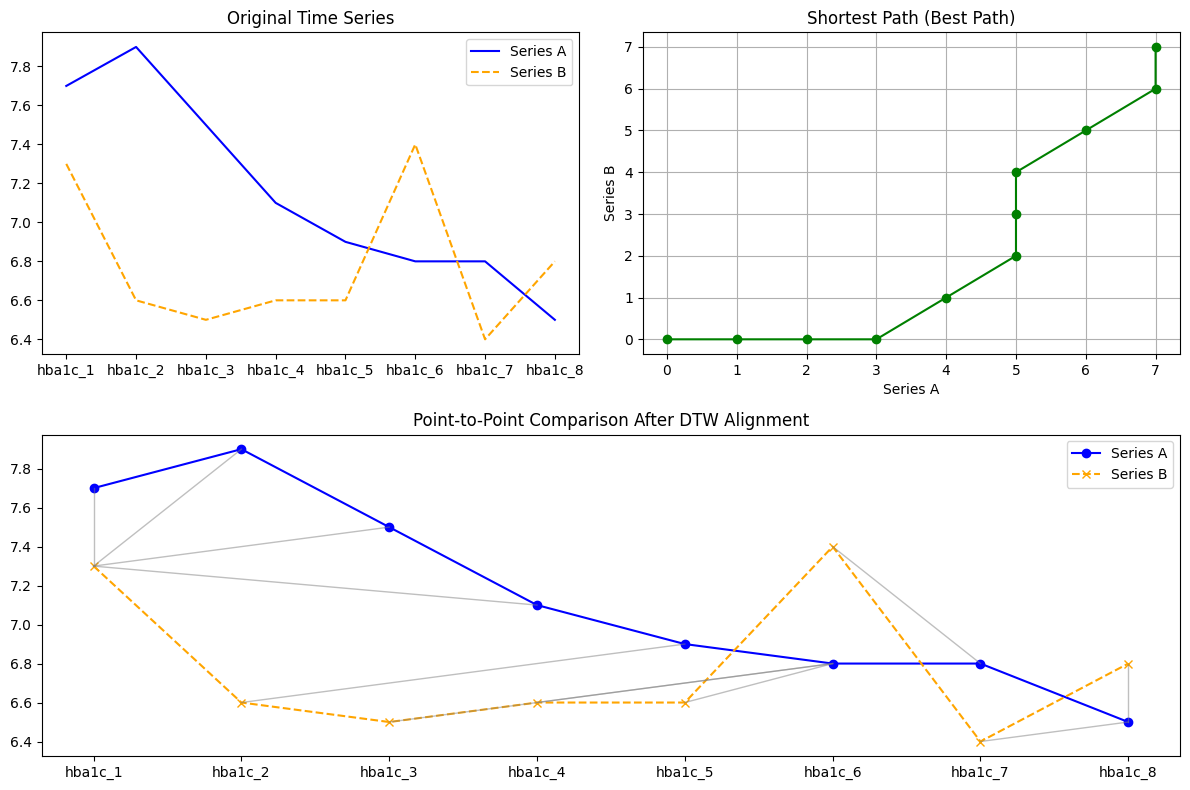

In [41]:
time_series_a = trayectorias_df.sample(1).iloc[0].dropna()
time_series_b = trayectorias_df.sample(1).iloc[0].dropna()

distance, paths = dtw.warping_paths(time_series_a, time_series_b)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

print(distance)

plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(time_series_a, label='Series A', color='blue')
ax1.plot(time_series_b, label='Series B', linestyle='--',color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
# In this example, only the path is plotted, not the entire cost matrix.

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('Series A')
ax2.set_ylabel('Series B')
ax2.grid(True)

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(time_series_a, label='Series A', color='blue', marker='o')
ax3.plot(time_series_b, label='Series B', color='orange', marker='x', linestyle='--')
for a, b in best_path:
    ax3.plot([a, b], [time_series_a[a], time_series_b[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

In [8]:
distancias_trayectorias_mtz = [trayectoria[~np.isnan(trayectoria)].tolist() for trayectoria in trayectorias_df.values]
distancias_trayectorias_mtz = dtw.distance_matrix(distancias_trayectorias_mtz)
distancias_trayectorias_mtz

array([[ 0.        , 10.77032961, 10.00099995, ..., 16.37711818,
        18.83587004, 17.71186043],
       [10.77032961,  0.        ,  3.71214224, ...,  5.96908703,
         7.58617163,  5.54887376],
       [10.00099995,  3.71214224,  0.        , ...,  5.55427763,
         9.24716173,  6.26976874],
       ...,
       [16.37711818,  5.96908703,  5.55427763, ...,  0.        ,
         4.06448029,  3.06920185],
       [18.83587004,  7.58617163,  9.24716173, ...,  4.06448029,
         0.        ,  2.61151297],
       [17.71186043,  5.54887376,  6.26976874, ...,  3.06920185,
         2.61151297,  0.        ]])

2.026211352201503


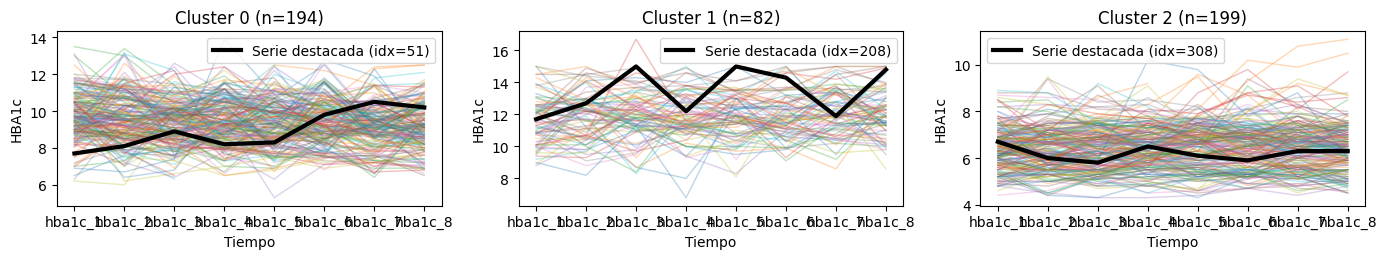

In [42]:
no_clusters = 3
cluster_labels = list(range(no_clusters))

kmedoids = KMedoids(n_clusters=no_clusters, metric='precomputed', method="pam")
solution = kmedoids.fit_predict(distancias_trayectorias_mtz)

print(trayectorias_fitness_func(solution, cluster_labels, distancias_trayectorias_mtz))
#plot_time_series_clusters(df=trayectorias_df, solution=solution, medoids=kmedoids.medoid_indices_)
plot_time_series_clusters_random(df=trayectorias_df, solution=solution)

In [12]:
trayectorias_sol_df = data_df.copy()
trayectorias_sol_df = trayectorias_sol_df.loc[trayectorias_df.index]
trayectorias_sol_df["Cluster"] = solution
trayectorias_sol_df["Cluster"] = trayectorias_sol_df["Cluster"].astype(int)

cluster_trayectorias_df = trayectorias_sol_df[trayectorias_sol_df["Cluster"] == 1].copy()

trayectorias_sol_df[[
    "Cluster", "enfermedadcardiovascular", "enfermedadrenal", "neuropatía", "lesiones", "has"
]].groupby("Cluster").mean()

,enfermedadcardiovascular,enfermedadrenal,neuropatía,lesiones,has
Cluster,,,,,
0,0.123711,0.067010,0.175258,0.041237,0.247423
1,0.036585,0.036585,0.268293,0.060976,0.170732
2,0.010050,0.015075,0.060302,0.010050,0.080402


In [40]:
complicaciones_df = data_df.copy()
complicaciones_df = complicaciones_df.loc[trayectorias_df.index]
complicaciones_df = complicaciones_df[[
    "enfermedadcardiovascular", "enfermedadrenal", "neuropatía", "lesiones", "has", "causa_muerte"
]]
complicaciones_df = pd.get_dummies(complicaciones_df, columns=["causa_muerte"]) * 1
causas_muerte_cols = complicaciones_df.columns[complicaciones_df.columns.str.startswith("causa_muerte")]
complicaciones_df.columns = complicaciones_df.columns[~complicaciones_df.columns.str.startswith("causa_muerte")].tolist() + \
                            causas_muerte_cols.str.removesuffix(".0").tolist()
complicaciones_df

,enfermedadcardiovascular,enfermedadrenal,neuropatía,lesiones,has,causa_muerte_1,causa_muerte_2,causa_muerte_3,causa_muerte_4,causa_muerte_5,causa_muerte_6,causa_muerte_7,causa_muerte_8,causa_muerte_9,causa_muerte_10,causa_muerte_13,causa_muerte_14
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
988,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
frecuencias_df = complicaciones_df.apply(lambda col: col.value_counts(), axis=0)
probas_df = frecuencias_df/len(complicaciones_df)
probas_df

,enfermedadcardiovascular,enfermedadrenal,neuropatía,lesiones,has,causa_muerte_1,causa_muerte_2,causa_muerte_3,causa_muerte_4,causa_muerte_5,causa_muerte_6,causa_muerte_7,causa_muerte_8,causa_muerte_9,causa_muerte_10,causa_muerte_13,causa_muerte_14
0,0.938947,0.96,0.856842,0.968421,0.835789,0.972632,0.989474,0.995789,0.995789,0.983158,0.995789,0.989474,0.995789,0.995789,0.997895,0.997895,0.991579
1,0.061053,0.04,0.143158,0.031579,0.164211,0.027368,0.010526,0.004211,0.004211,0.016842,0.004211,0.010526,0.004211,0.004211,0.002105,0.002105,0.008421


In [532]:
N = len(complicaciones_df)
distancias_complicaciones_mtz = np.zeros((N, N))
for i in range(N):
    print(i)
    for j in range(i, N):
        x = complicaciones_df.iloc[[i]]
        y = complicaciones_df.iloc[[j]]
        distancia_goodall1 = goodall1_distance(x, y, N, frecuencias_df)
        distancias_complicaciones_mtz[i, j] = distancia_goodall1
        distancias_complicaciones_mtz[j, i] = distancia_goodall1

distancias_complicaciones_mtz

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

array([[0.90189547, 0.90189547, 0.90189547, ..., 0.90189547, 0.95914985,
        0.90189547],
       [0.90189547, 0.90189547, 0.90189547, ..., 0.90189547, 0.95914985,
        0.90189547],
       [0.90189547, 0.90189547, 0.90189547, ..., 0.90189547, 0.95914985,
        0.90189547],
       ...,
       [0.90189547, 0.90189547, 0.90189547, ..., 0.90189547, 0.95914985,
        0.90189547],
       [0.95914985, 0.95914985, 0.95914985, ..., 0.95914985, 0.94296926,
        0.95914985],
       [0.90189547, 0.90189547, 0.90189547, ..., 0.90189547, 0.95914985,
        0.90189547]])

0.476848128056994


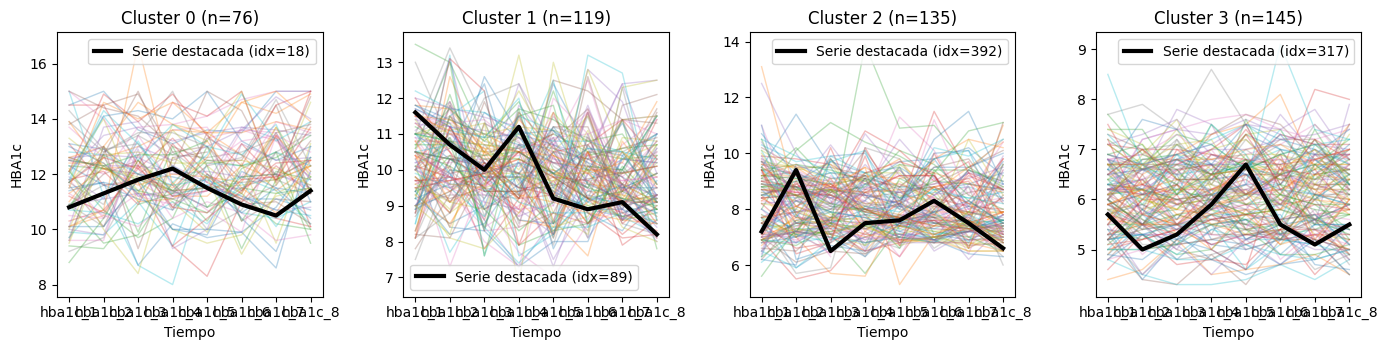

In [600]:
distancias_complicaciones_mtz_normalizadas = similarity.squash(distancias_complicaciones_mtz)
distancias_trayectorias_mtz_normalizadas = similarity.squash(distancias_trayectorias_mtz)

distancias_combinadas_mtz = 0.1 * distancias_complicaciones_mtz_normalizadas + 0.9 * distancias_trayectorias_mtz_normalizadas

no_clusters = 4
cluster_labels = list(range(no_clusters))

kmedoids = KMedoids(n_clusters=no_clusters, metric='precomputed', method="pam")
solution = kmedoids.fit_predict(distancias_combinadas_mtz)

print(trayectorias_fitness_func(solution, cluster_labels, distancias_combinadas_mtz))
#plot_time_series_clusters(df=trayectorias_df, solution=solution, medoids=kmedoids.medoid_indices_)
plot_time_series_clusters_random(df=trayectorias_df, solution=solution)

In [601]:
trayectorias_sol_df = data_df.copy()
trayectorias_sol_df = trayectorias_sol_df.loc[trayectorias_df.index]
trayectorias_sol_df["Cluster"] = solution
trayectorias_sol_df["Cluster"] = trayectorias_sol_df["Cluster"].astype(int)
causas_muerte_cols = complicaciones_df.columns[complicaciones_df.columns.str.startswith("causa_muerte")]
trayectorias_sol_df[causas_muerte_cols] = complicaciones_df[causas_muerte_cols].copy()


trayectorias_sol_df[
    ["Cluster", "enfermedadcardiovascular", "enfermedadrenal", "neuropatía", "lesiones", "has"] + causas_muerte_cols.tolist()
].groupby("Cluster").mean()

,enfermedadcardiovascular,enfermedadrenal,neuropatía,lesiones,has,causa_muerte_1,causa_muerte_2,causa_muerte_3,causa_muerte_4,causa_muerte_5,causa_muerte_6,causa_muerte_7,causa_muerte_8,causa_muerte_9,causa_muerte_10,causa_muerte_13,causa_muerte_14
Cluster,,,,,,,,,,,,,,,,,
0,0.039474,0.026316,0.263158,0.052632,0.157895,0.000000,0.000000,0.000000,0.000000,0.013158,0.013158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.142857,0.075630,0.176471,0.050420,0.260504,0.033613,0.016807,0.000000,0.000000,0.025210,0.000000,0.025210,0.016807,0.008403,0.000000,0.000000,0.000000
2,0.059259,0.044444,0.133333,0.029630,0.207407,0.044444,0.022222,0.007407,0.014815,0.022222,0.007407,0.014815,0.000000,0.007407,0.007407,0.007407,0.014815
3,0.006897,0.013793,0.062069,0.006897,0.048276,0.020690,0.000000,0.006897,0.000000,0.006897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013793
